In [48]:
import xarray as xr

# from credit.models.skebs_model import SKEBS
from matplotlib import pyplot as plt
import numpy as np
import torch_harmonics as harmonics
from credit.physics_constants import PI, RAD_EARTH, OMEGA, GRAVITY
import torch
from credit.xr_sampler import XRSamplerByYear 
from glob import glob
from os.path import join
import yaml
import os
import datetime

In [49]:
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_12_24h"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_24h"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/conv_12h_skebs"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_36h_skebs"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_12h_train_a_filter"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_12h_backscatter_filter/"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_6_12h"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_6_12h_train_filter"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained"

raw = True



all_rollout_files = glob(join(rollout_dir, "backscatter/backscatter_*"))
filtered_files = [file for file in all_rollout_files if "raw" not in file]
raw_files = [file for file in all_rollout_files if "raw" in file]

if raw:
    all_rollout_files = raw_files
else:
    all_rollout_files = filtered_files

rollout_files = all_rollout_files[:len(all_rollout_files) // 2]

config = join(rollout_dir, "model.yml")
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

static_ds = xr.open_dataset(conf["data"]["save_loc_static"])

print(datetime.datetime.fromtimestamp(os.path.getmtime(rollout_files[0])).strftime('%m/%d/%Y'))


03/19/2025


In [50]:
rollout_files = rollout_files

In [51]:
def load_files_and_concat(rollout_files):
    arrays = []
    for file in rollout_files:
        arr = torch.load(file, map_location="cpu").unsqueeze(0)
        arrays.append(arr)
    all_concat = torch.concat(arrays, dim=0)
    return all_concat

In [52]:
a = load_files_and_concat(rollout_files)
a.shape

/glade/derecho/scratch/dkimpara/tmp/ipykernel_23741/2863617089.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  arr = torch.load(file, map_location="cpu").unsqueeze(0)


torch.Size([660, 16, 32, 1, 192, 288])

In [53]:
zonal_mean = a.mean(dim=-1).mean(dim=[0,1]).squeeze() #lon mean, then ensemble mean
da = xr.DataArray(zonal_mean, coords={"level": np.arange(zonal_mean.shape[0]),
                                      "latitude": static_ds.latitude})
print(da.max())
#da.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)
berner_levels = np.concatenate([np.linspace(0, 10, 14), 
                                np.linspace(10, 20, 7),
                               np.linspace(20, 30, 3),
                               np.linspace(30, 40, 8)], axis=0)
da_berner = da.assign_coords(level=berner_levels)


<xarray.DataArray ()> Size: 8B
array(810.14916992)


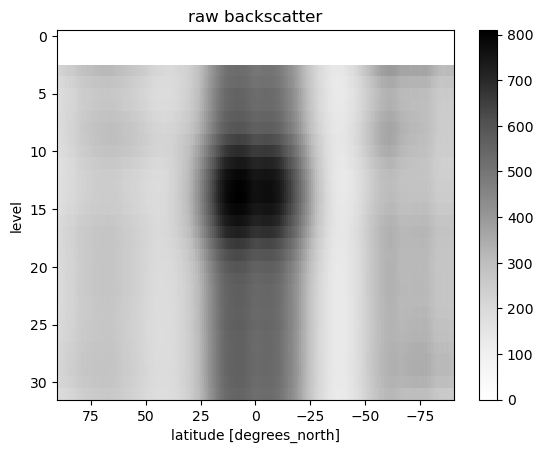

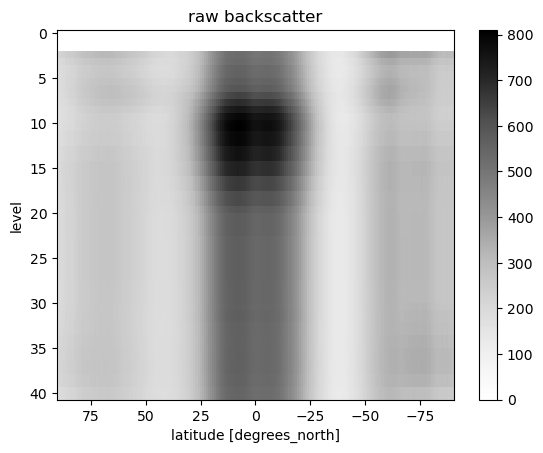

In [54]:
da.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)
if raw:
    plt.title("raw backscatter")
else:
    plt.title("filtered backscatter")
plt.show()
da_berner.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)
if raw:
    plt.title("raw backscatter")
else:
    plt.title("filtered backscatter")
plt.show()

In [55]:
rmse_magnitudes = xr.open_dataset("/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/forecast/magnitudes_fhmean_lat_lev_unwted_2012-06-05_15dayforecast_16dayinterval.nc")

In [56]:
da_scaled = da * (np.sqrt(rmse_magnitudes["U"] **2 + rmse_magnitudes["V"] ** 2)) / (np.sqrt(rmse_magnitudes["U"] **2 + rmse_magnitudes["V"] ** 2)).sum()


da_berner_scaled = da_scaled.assign_coords(level=berner_levels)


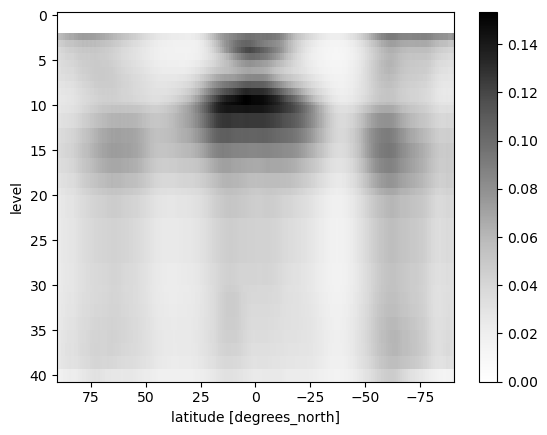

In [57]:
da_berner_scaled.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

# plot by time

In [58]:
a.shape

torch.Size([660, 16, 32, 1, 192, 288])

In [59]:
forecast_days = 15
total_steps = forecast_days * 4

def zonal_mean_by_fh(eval_fh):
    eval_indices = (eval_fh) / 6 - 1 + np.arange(0, a.shape[0], total_steps)
    eval_data = a[eval_indices[:2]].squeeze() #b, ens, c, t, lat, lon
    zonal_mean = eval_data.mean(dim=-1).mean(dim=[0,1])
    da = xr.DataArray(zonal_mean, coords={"level": np.arange(zonal_mean.shape[0]),
                                      "latitude": static_ds.latitude})
    return da # da with coords level and latitude

berner_levels = np.concatenate([np.linspace(0, 10, 14), 
                                np.linspace(10, 20, 7),
                               np.linspace(20, 30, 3),
                               np.linspace(30, 40, 8)], axis=0)

def plot_backscatter(da, fh):
    da_berner = da.assign_coords(level=berner_levels)
    da_berner.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0, vmax=40)
    plt.title(f"fh={fh} | day {fh / 24} averaged backscatter")
    plt.show()



## plot graph of average across time

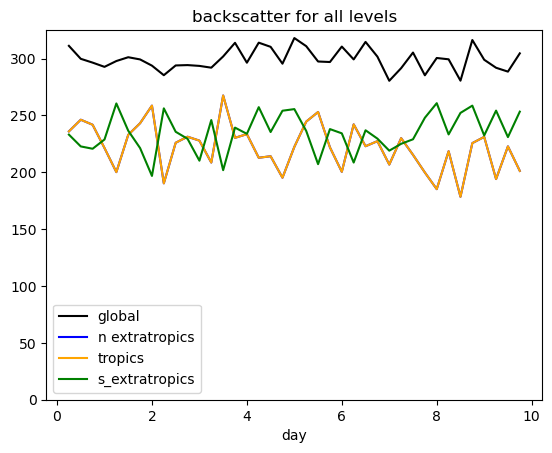

In [60]:
means = []
n_means = []
tropics_means = []
s_means = []

for eval_fh in range(6,240,6):
    backscatter_mean = zonal_mean_by_fh(eval_fh).mean()
    means.append(backscatter_mean)

    backscatter_mean = zonal_mean_by_fh(eval_fh).sel(latitude=slice(24.5, 91)).mean()
    n_means.append(backscatter_mean)

    backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-24.5,24.5)).mean()
    tropics_means.append(backscatter_mean)

    backscatter_mean = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-91,-24.5)).mean()
    s_means.append(backscatter_mean)

days = np.arange(1, len(means)+1) / 4
plt.plot(days, means, label="global", c="0")
plt.plot(days, n_means, label="n extratropics", c="b")
plt.plot(days, tropics_means, label="tropics", c="orange")
plt.plot(days, s_means, label="s_extratropics", c="g")

plt.title("backscatter for all levels")
plt.xlabel("day")

plt.ylim(0)
plt.legend()
    

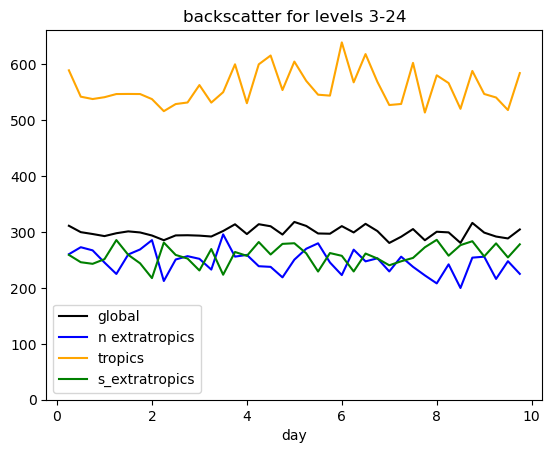

In [61]:
means = []
n_means = []
tropics_means = []
s_means = []

for eval_fh in range(6,240,6):
    backscatter_mean = zonal_mean_by_fh(eval_fh).mean()
    means.append(backscatter_mean)

    backscatter_mean = zonal_mean_by_fh(eval_fh).sel(latitude=slice(24.5, 91), level=slice(3,24.5)).mean()
    n_means.append(backscatter_mean)

    backscatter_mean = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-24.5,24.5), level=slice(3,24.5)).mean()
    tropics_means.append(backscatter_mean)

    backscatter_mean = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-91,-24.5), level=slice(3,24.5)).mean()
    s_means.append(backscatter_mean)

days = np.arange(1, len(means)+1) / 4
plt.plot(days, means, label="global", c="0")
plt.plot(days, n_means, label="n extratropics", c="b")
plt.plot(days, tropics_means, label="tropics", c="orange")
plt.plot(days, s_means, label="s_extratropics", c="g")

plt.title("backscatter for levels 3-24")
plt.xlabel("day")
plt.ylim(0)
plt.legend()
    

In [62]:
## quantiles

In [63]:
# all = []
# north = []
# tropics = []
# south = []

# for eval_fh in range(6,240,6):
#     backscatter_statistic = zonal_mean_by_fh(eval_fh).quantile(q=0.95)
#     all.append(backscatter_statistic)

#     backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(24.5, 91)).quantile(q=0.95)
#     north.append(backscatter_statistic)

#     backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-24.5,24.5)).quantile(q=0.95)
#     tropics.append(backscatter_statistic)

#     backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-91,-24.5)).quantile(q=0.95)
#     south.append(backscatter_statistic)

# days = np.arange(1, len(means)+1) / 4
# plt.plot(days, all, label="global", c="0")
# plt.plot(days, north, label="n extratropics", c="b")
# plt.plot(days, tropics, label="tropics", c="orange")
# plt.plot(days, south, label="s_extratropics", c="g")

# plt.title("0.95 quantile of zonally averaged backscatter across 22 inits for all levels")
# plt.xlabel("day")

# plt.ylim(0)
# plt.legend()
    

In [64]:
# all = []
# north = []
# tropics = []
# south = []

# for eval_fh in range(6,240,6):
#     backscatter_statistic = zonal_mean_by_fh(eval_fh).quantile(q=0.95)
#     all.append(backscatter_statistic)

#     backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(24.5, 91), level=slice(3,24.5)).quantile(q=0.95)
#     north.append(backscatter_statistic)

#     backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-24.5,24.5), level=slice(3,24.5)).quantile(q=0.95)
#     tropics.append(backscatter_statistic)

#     backscatter_statistic = zonal_mean_by_fh(eval_fh).sel(latitude=slice(-91,-24.5), level=slice(3,24.5)).quantile(q=0.95)
#     south.append(backscatter_statistic)

# days = np.arange(1, len(means)+1) / 4
# plt.plot(days, all, label="global", c="0")
# plt.plot(days, north, label="n extratropics", c="b")
# plt.plot(days, tropics, label="tropics", c="orange")
# plt.plot(days, south, label="s_extratropics", c="g")

# plt.title("0.95 quantile of zonally averaged backscatter across 22 inits for levels 3-24")
# plt.xlabel("day")

# plt.ylim(0)
# plt.legend()

## plot spatial across time 

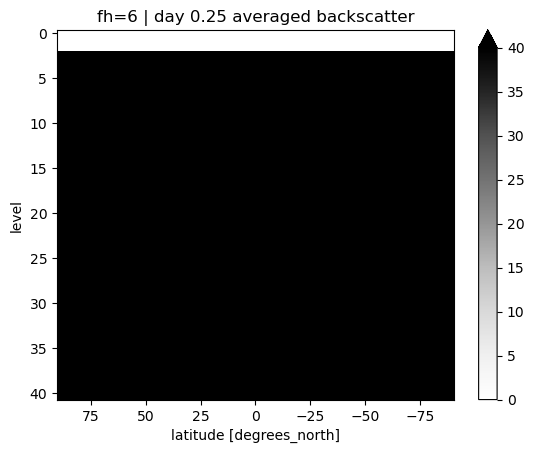

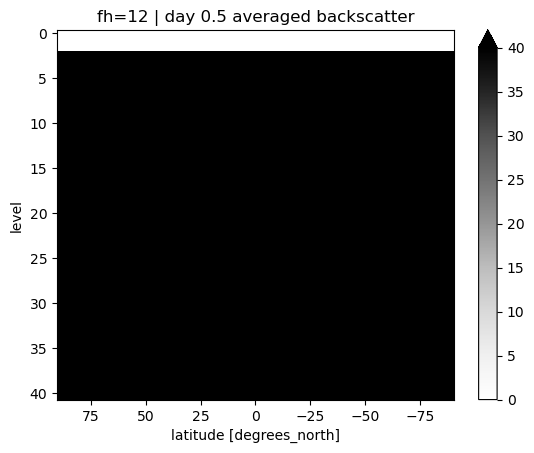

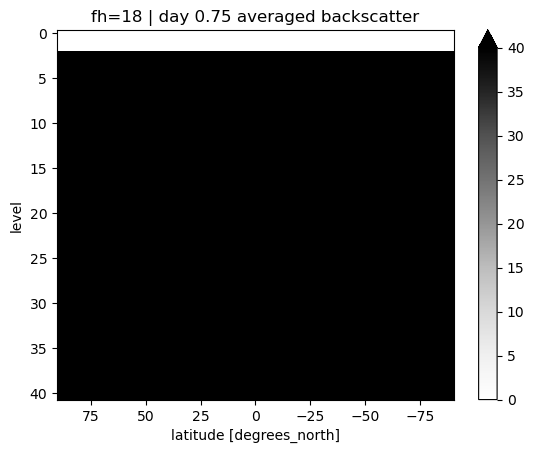

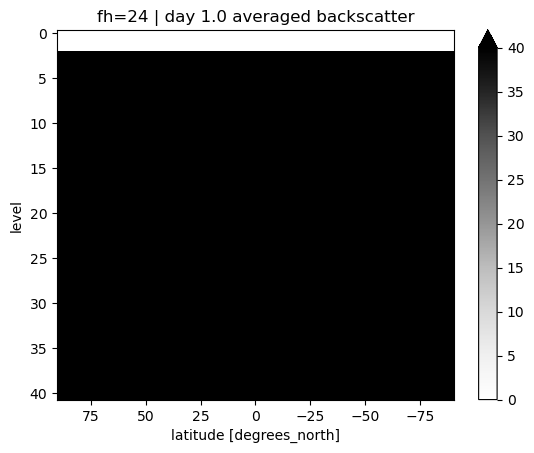

In [65]:
for eval_fh in range(6,25,6):
    da = zonal_mean_by_fh(eval_fh)
    plot_backscatter(da, eval_fh)

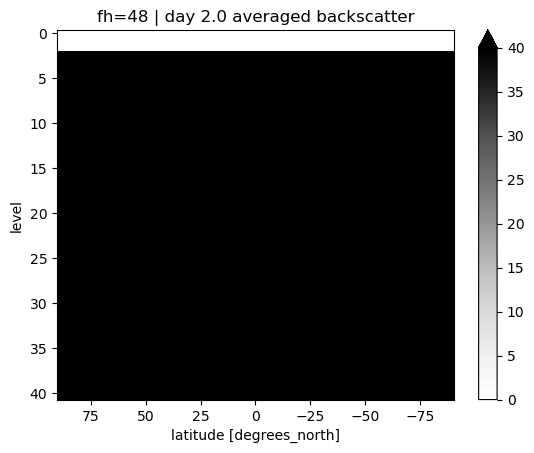

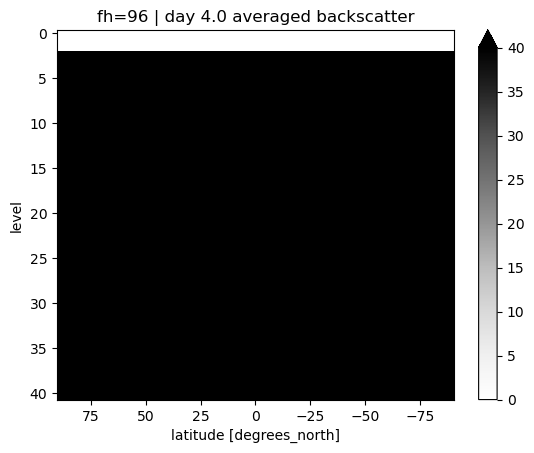

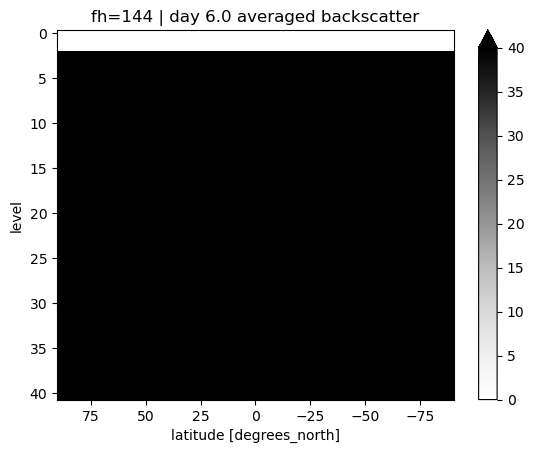

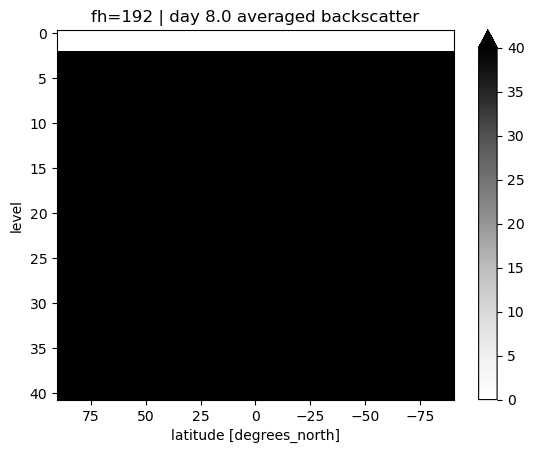

In [66]:
for eval_fh in range(48,48 * 4 + 1,48):
    da = zonal_mean_by_fh(eval_fh)
    plot_backscatter(da, eval_fh)